In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm, lognorm
import pandas as pd
from astropy.io import fits

# Leonardo Cecchini                                                                      
## A.A. 2023/2024  

##          Analisi dei profili di densità degli aloni di materia oscura secondo la teoria NFW

Lo scopo di questa analisi è visualizzare i profili di densità degli aloni di materia oscura e stimare, a partire da dei dati generati con una simulazione cosmologica, dei parametri confrontandoli con i dati ottenuti dalle simulazioni Monte Carlo Markov Chain (MCMC).

Nella prima parte si procede alla visualizzazione del profilo di densità per diversi valori di $M$ (massa dell'alone), $c$ (concentrazione) a $z$ (redshift) fissato. Il profilo di densità è dato dalla formula NFW proiettata in 2 dimensioni. La formula è implementata nella seguente cella di codice:

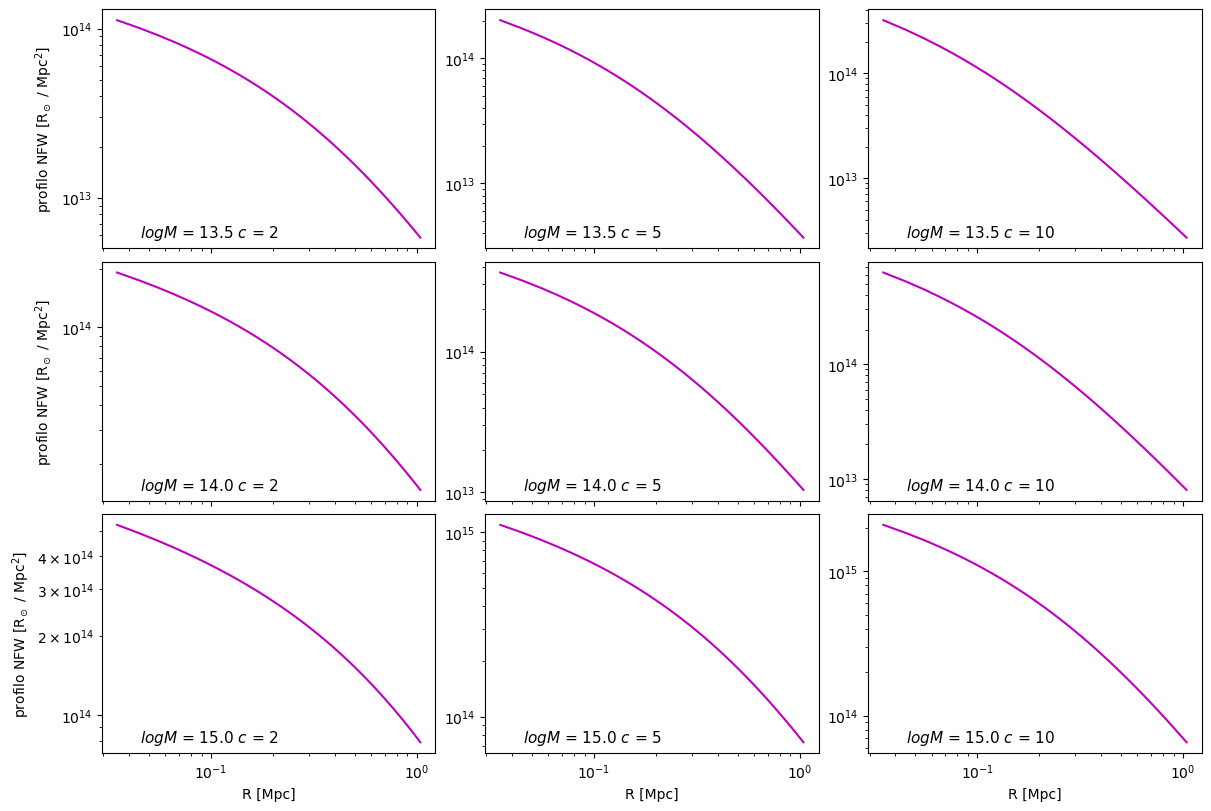

In [2]:
rho_m = 0.286 * (0.7**2) * 2.7751428946*((10)**11)

#Definisco le varie funzioni per calcolare il profilo di densità
def r_s(M, c, z):
    return ((M*3/(4*np.pi*200*rho_m*(1 + z)**3))**(1.0/3))/c

def rho_s(c, z):
    fc = np.log(1 + c) - (c/(1+c))
    d_char = (200*(c**3))/(3*fc)
    return rho_m*((1 + z)**3)*d_char

def f(R, M, c, z):
    x = R/r_s(M, c, z)
    f1 = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]<1:
            f1[i] = (1.0 - (2.0*np.arctanh(np.sqrt((1-x[i])/(1+x[i])))/np.sqrt(1 - x[i]**2)))/(x[i]**2 -1)
        elif x[i]==1:
            f1[i] = 1.0/3
        elif x[i]>1:
            f1[i] = (1.0 - (2.0*np.arctan(np.sqrt((x[i]-1)/(1+x[i])))/np.sqrt(x[i]**2 - 1)))/(x[i]**2 -1)
    return f1

def NFW(R, M, c, z): #Questo è il profilo di densità proiettato
    return 2.0 * r_s(M, c, z) * rho_s(c, z) * f(R, M, c, z)

xr = np.linspace(0.035, 1.04, 100)
M = [10**13.5, 10**14.0, 10**15.0]
c = [2, 5, 10]
z = 0.0

fig, ax = plt.subplots(3, 3, figsize=(12,8), layout='constrained', sharex=True)
for i in range(3):
    for k in range(3):
        ax[i,k].set_xscale("log")
        ax[i,k].set_yscale("log")
        y = NFW(xr, M[i], c[k], z)
        ax[i, k].plot(xr, y, color = 'm')
        ax[i, k].annotate(f"$logM$ = {np.log10(M[i])} $c$ = {c[k]}", (xr[1], y[-1]), fontsize=11)
        

for i in range(3):
    ax[i, 0].set_ylabel('profilo NFW [R$_\odot$ / Mpc$^2$]')
    ax[2, i].set_xlabel("R [Mpc]")
    
plt.show() #Ora osserviamo i vari profili con un plot

### Osservazioni:
Gli andamenti sono molto simili tra loro, sebbene i grafici siano spostati più in alto man man che aumenta $logM$. Si nota anche una salita da sinistra verso destra, ovvero aumentando la concentrazione $c$. In generale, i grafici sono tutti descrescenti, come ci si poteva aspettare.

Ora passiamo ai 40103 dati ottenuti con le simulazioni cosmologiche. Questi contengono i profili di densità, redshift e la ricchezzza, ovvero una somma pesata dele galassie dell'alone. per scaricare il file mi avvalgo di 'fits' importato dalla libreria 'astropy'.


In [3]:
data = fits.getdata('halo_catalog.fit')
#print(data) Diamo un'occhiata ai dati
#np.shape(data)
Rdati = np.load('R_values.npy')
#np.shape(Rdati) data è una matrice 40103*8; il numero di colonne coincide con la dimensione di Rdati
print(Rdati)

[0.04056329 0.06397266 0.10089175 0.15911711 0.25094477 0.39576683
 0.62416676 0.98437798]


In [4]:
redsh = data['Z']
print(redsh) 
rich = data['LAMBDA_TR']
print(rich)
prof_dens = data['SIGMA_OF_R']
print(prof_dens)
#np.shape(prof_dens)

[0.5024944  0.6013021  0.20896086 ... 0.62278223 0.5350497  0.49350488]
[290.69226  119.24578  126.37386  ...   8.831167  12.180819  17.996544]
[[2.3511019e+15 1.9926530e+15 1.4960676e+15 ... 6.2538569e+14
  3.9431326e+14 2.2858141e+14]
 [2.1076592e+15 1.9800638e+15 1.6522259e+15 ... 7.1246280e+14
  4.4937364e+14 2.6246439e+14]
 [1.8141370e+15 1.7395870e+15 1.3446392e+15 ... 5.9419329e+14
  3.6682020e+14 1.8649746e+14]
 ...
 [6.4192762e+14 4.4268980e+14 3.8348431e+14 ... 1.0977853e+14
  7.1850374e+13 5.3261927e+13]
 [3.1632605e+14 3.3178146e+14 2.4914610e+14 ... 1.2830642e+14
  8.7231272e+13 5.7606391e+13]
 [6.8748609e+14 4.9900034e+14 3.6549980e+14 ... 9.1625745e+13
  5.0506773e+13 3.6525597e+13]]


Valori medi di redshift= [0.46009004 0.46388739 0.45920765 0.45643923 0.44116071]


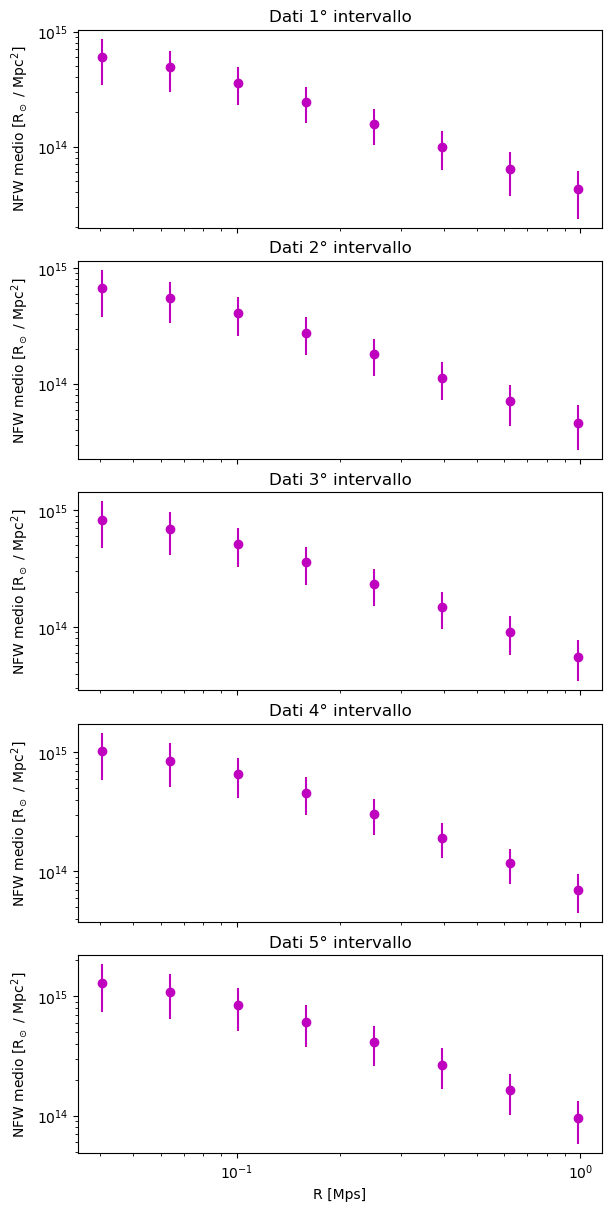

In [5]:
rich_interv = [15,20,30,45,60,200] 
#Questi sono gli estremi dei 5 intervalli; per ognuno di essi si fa un grafico del redshift medio e profilo medio con 
#la deviazione standard
fig, ax = plt.subplots(5, 1, figsize=(6,12), layout='constrained', sharex=True)
redsh_mid = np.zeros(5)
prof_dens_mid = np.zeros((5,8))
prof_dens_stdev = np.zeros((5,8))
#Ora raggruppo i dati in base alla ricchezza
for i in range(5):
    dati2 = data[(rich <= rich_interv[i+1]) & (rich >= rich_interv[i])]
    redsh_mid[i] = np.mean(dati2['Z'])
    prof_dens_mid[i] = np.mean(dati2['SIGMA_OF_R'], axis=0) #Come notato prima, per i profili di densità avrò otto medie e dev. stand.
    prof_dens_stdev[i] = np.std(dati2['SIGMA_OF_R'], axis=0)
#Ora posso procedere a graficare i dati in scala loglog
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    #ax[i].plot(Rdati,prof_dens_mid[i], color='orange') Più corretto senza linea spezzata, tanto poi c'è il fit
    ax[i].errorbar(Rdati, prof_dens_mid[i], yerr = prof_dens_stdev[i], fmt='o',color='m')
    ax[i].set_title(f'Dati {i+1}° intervallo')
    ax[i].set_ylabel('NFW medio [R$_\odot$ / Mpc$^2$]')
ax[-1].set_xlabel('R [Mps]')
print('Valori medi di redshift=', redsh_mid) #Faccio comparire anche i valori di redshift medi oltre ai grafici
plt.show()

### Osservazioni: 
I grafici sono molto simili tra loro, sebbene con l'aumentare della ricchezza degli intervalli i valori delle curve diventino più grandi. Ciò è giustificato dal fatto che la ricchezza è la somma pesata delle galassie nell'alone; maggiore è la ricchezza, più denso è l'alone.
Si nota inoltre una notevole somiglianza con i grafici ottenuti prima dalla formula, almeno per quanto riguarda la forma che sembrano assumere i punti. Nella seguente parte vedremo se effettivamente i best fit seguono l'andamento previsto in accordo con i punti.

Ora procederemo con l'analisi statistica vera e propria. Stimeremo $logM$ e $c$ per ogni intervallo di ricchezza mediante l'algoritmo di Emcee. Come Likelihood useremo una Gaussiana con una matrice di covarianza letta da un opportuno file di dati.

100%|██████████| 2100/2100 [00:12<00:00, 163.90it/s]
C:\Users\leona\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 2100/2100 [00:12<00:00, 162.93it/s]
C:\Users\leona\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 2100/2100 [00:13<00:00, 155.48it/s]


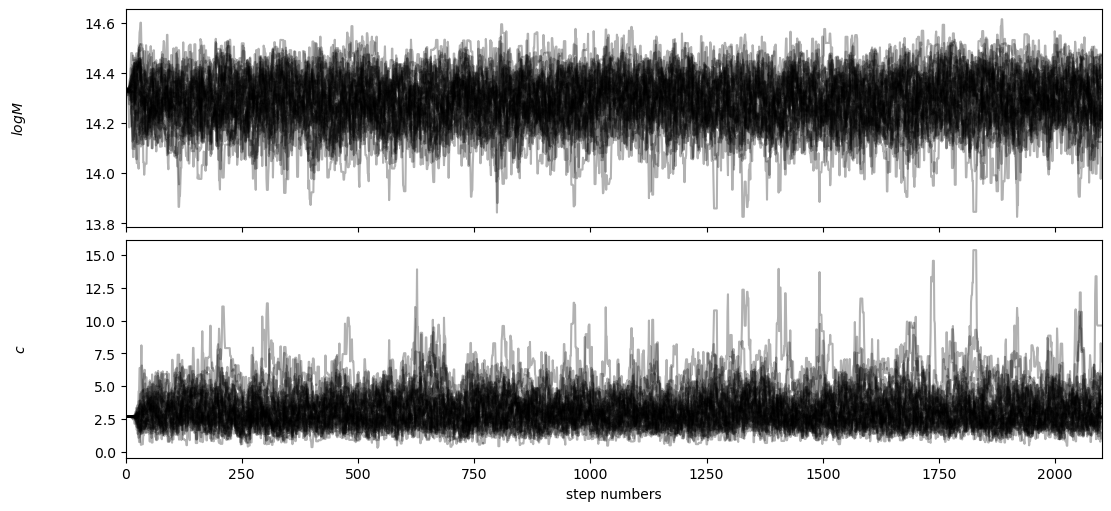

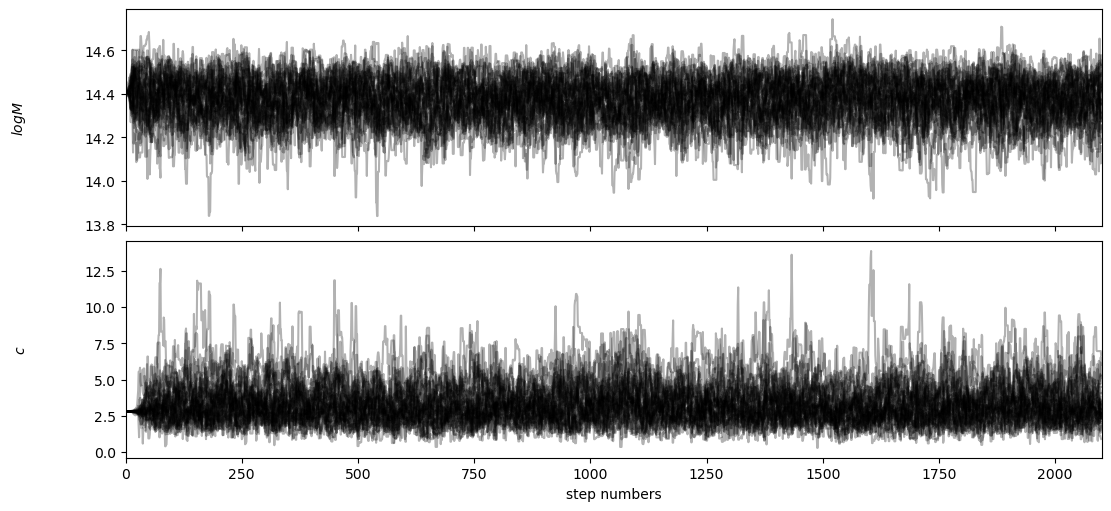

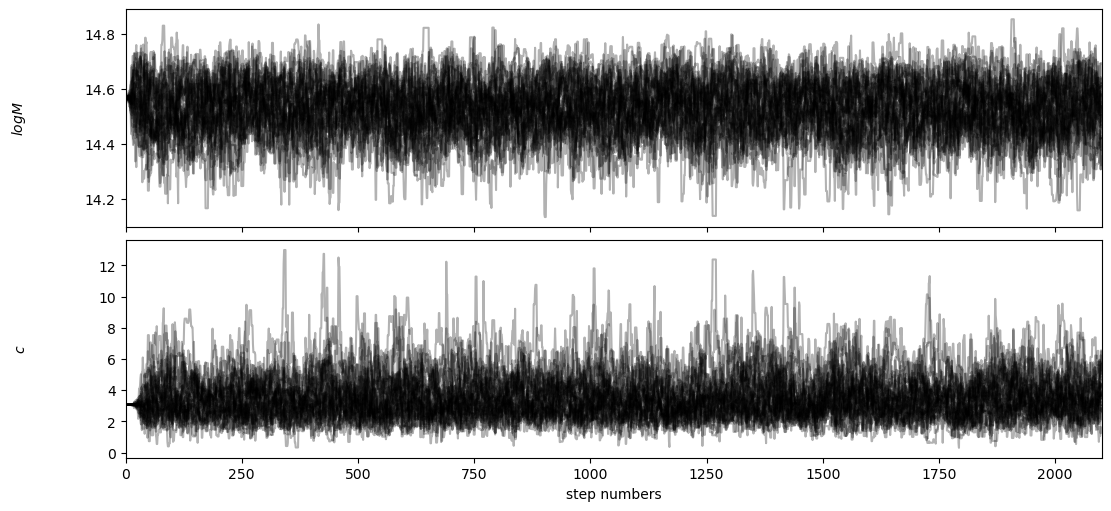

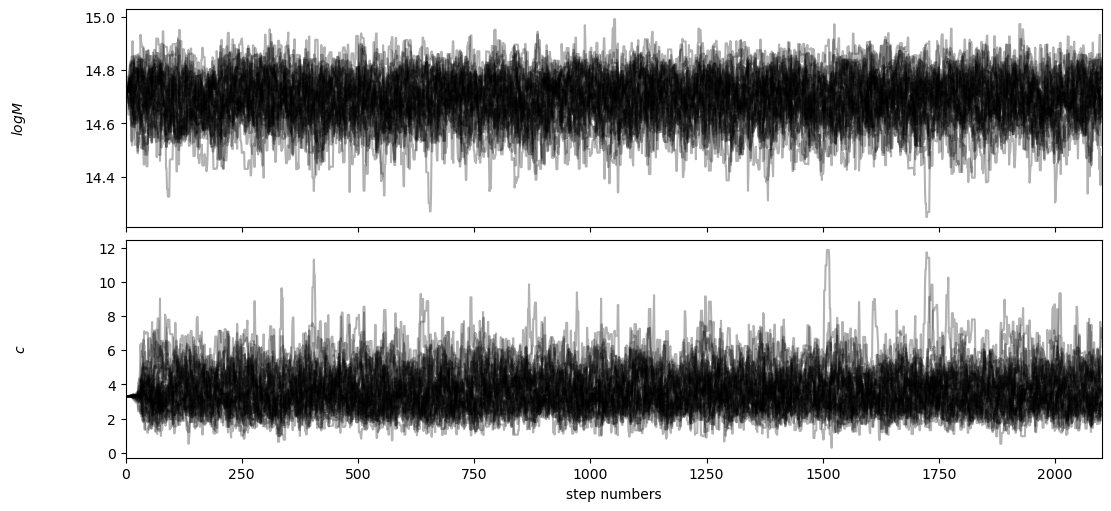

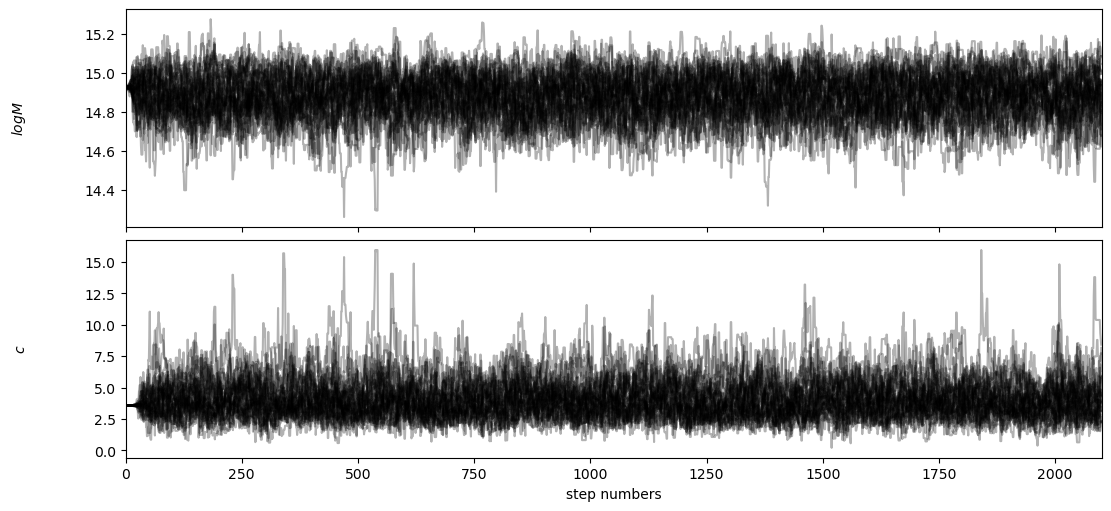

In [6]:
import emcee
matcov = np.load('covariance_matrices.npy')
#print(matcov[0])

def log_prior(theta): #Come al solito lavoriamo con logaritmi per trasformare la produttoria in sommatoria
    logM, c = theta
    if 13.0<=logM<=16.0 and 0.2<=c<=20:
        return 0.0
    return -np.inf

def log_Likelihood(theta, R, pdm, mcov, z):
    logM, c = theta
    M = 10**(logM) #così facendo logM rimane la variabile
    model = NFW(R, M, c, z)
    mcov_inversa = np.linalg.inv(mcov) #inverto la matrice
    return -0.5 * np.dot(pdm - model, np.dot(mcov_inversa, pdm - model)) #Questa è la formula implementata
    #Ci sarebbe un termine costante a moltiplicare ma con i logaritmi si riduce ad una somma di una costante
    
def log_posterior(theta, R, pdm, mcov, z):
    logM, c = theta
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_Likelihood(theta, R, pdm, mcov, z)

from scipy.optimize import minimize
bfit = np.zeros((5,2)) #Conviene definirlo così siccome abbiamo 5 intervalli
np.random.seed(42)
data_chain = np.zeros((5,64000,2)) #Preparo un array di dati generati dalla chain per la prossima consegna

for i in range(5):
    nll = lambda *args: -log_posterior(*args)
    initial = np.array([15.0, 3.0])*( 1 + 0.1*np.random.randn(2))
    soln = minimize(nll, initial, args=(Rdati, prof_dens_mid[i], matcov[i], redsh_mid[i]))
    logM, c = soln.x
    bfit[i] = soln.x
    
    pos = soln.x *(1 + 1e-4 * np.random.randn(32,2))
    nwalker, ndim = pos.shape
    
    sampler = emcee.EnsembleSampler(nwalker, ndim, log_posterior, args=(Rdati, prof_dens_mid[i], matcov[i], redsh_mid[i]))
    sampler.run_mcmc(pos, 2100, progress=True)
    data_chain[i] = sampler.get_chain(discard=100 , flat=True) #scartiamo i valori di burn_in e salviamo i dati
    
    fig, ax = plt.subplots(2, figsize=(11,5), layout='constrained', sharex=True)
    samples = sampler.get_chain()
    labels=["$logM$","$c$" ]
    for k in range(ndim):
        AX = ax[k]
        AX.plot(samples[:,:,k], "k", alpha=0.3)
        AX.set_xlim(0,len(samples))
        AX.set_ylabel(labels[k])
        AX.yaxis.set_label_coords(-0.1, 0.5)
    ax[-1].set_xlabel("step numbers");

Valori di logM e c del 1° intervallo: [14.33028326  2.67712129]
Valori di logM e c del 2° intervallo: [14.40885302  2.79772725]
Valori di logM e c del 3° intervallo: [14.56837254  3.06711347]
Valori di logM e c del 4° intervallo: [14.72062523  3.31349508]
Valori di logM e c del 5° intervallo: [14.92337943  3.57161722]


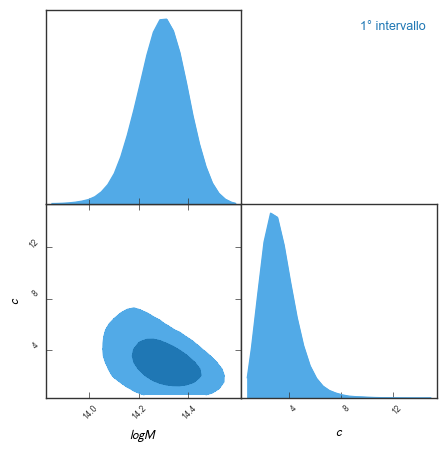

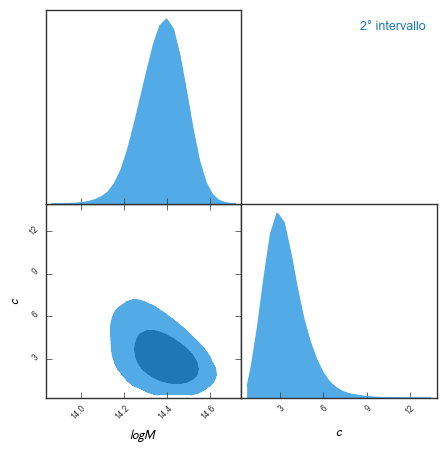

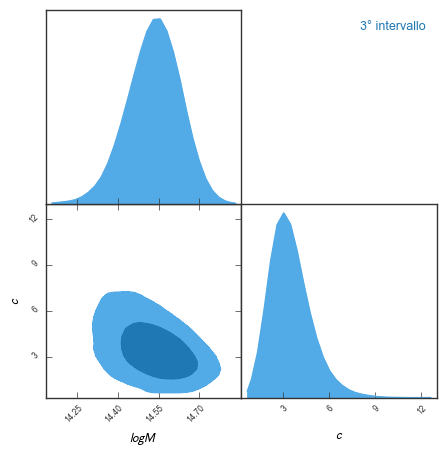

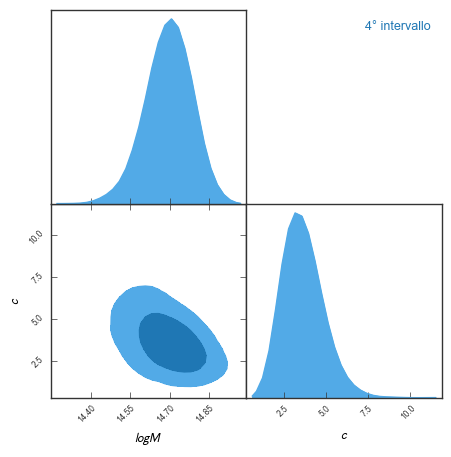

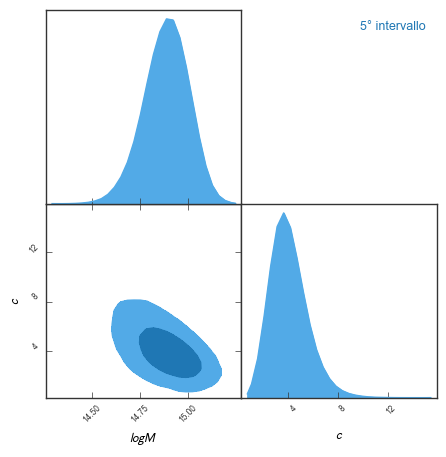

In [10]:
#Osserviamo le distribuzioni con un grafico triangolare
import pygtc
for i in range(5):
    print(f"Valori di logM e c del {i+1}° intervallo:", bfit[i]) #Facciamo anche vedere i valori di best fit
    GTC = pygtc.plotGTC(chains=data_chain[i], paramNames=['$logM$', '$c$'],
                       chainLabels=[f'{i+1}° intervallo'], figureSize='MNRAS_page')

### Osservazioni: 
I best fit ottenuti sembrano piuttosto promettenti. Infatti, come per i grafici di prima, i valori di $logM$ e $c$ crescono man mano che ci si sposta di intervallo di ricchezza. Il risultato assume ancora più valenza osservando i walkers nei grafici in alto e per mezzo del modulo "pygtc" possiamo anche visualizzare le "posterior distributions" tracciate da questi ultimi. 

Osservando le distribuzioni sembra che $logM$ abbia un andamento Gaussiano (leggermente asimmetrico), mentre la distibuzione di $c$ è più asimmetrica (più precisamente, è più ripida a sinistra mentre a destra la coda è più rilassata).

Confrontiamo ora i risultati con le medie e le deviazioni standard ottenute dalle chain salvate al punto precedente.

In [8]:
#Calcoliamo valore medio e deviazione standard dai dati salvati
logM_mid_chain = np.zeros(5)
logM_stdev_chain = np.zeros(5)
c_mid_chain = np.zeros(5)
c_stdev_chain = np.zeros(5)

for i in range(5):
    logM_mid_chain[i] = np.mean(data_chain[i,:,0])
    logM_stdev_chain[i] = np.std(data_chain[i,:,0])
    c_mid_chain[i] = np.mean(data_chain[i,:,1])
    c_stdev_chain[i] = np.std(data_chain[i,:,1])
    print(f'{i+1}° intervallo')
    print("Valore medio e dev. stand. di logM:", logM_mid_chain[i], logM_stdev_chain[i])
    print("Valore medio e dev. stand. di c:", c_mid_chain[i], c_stdev_chain[i])
    print()


1° intervallo
Valore medio e dev. stand. di logM: 14.290892950262569 0.09761207048228969
Valore medio e dev. stand. di c: 3.200571409331148 1.3491926886080832

2° intervallo
Valore medio e dev. stand. di logM: 14.374158710880875 0.09851079015000652
Valore medio e dev. stand. di c: 3.2995491642720767 1.3261248392110483

3° intervallo
Valore medio e dev. stand. di logM: 14.5311189198252 0.09520626539336173
Valore medio e dev. stand. di c: 3.4894705151231853 1.3147611679290532

4° intervallo
Valore medio e dev. stand. di logM: 14.694987164267431 0.08683935107375607
Valore medio e dev. stand. di c: 3.6354769174493726 1.1775197330381226

5° intervallo
Valore medio e dev. stand. di logM: 14.88382422069893 0.11239910584627746
Valore medio e dev. stand. di c: 4.02844596831974 1.4575753265966596



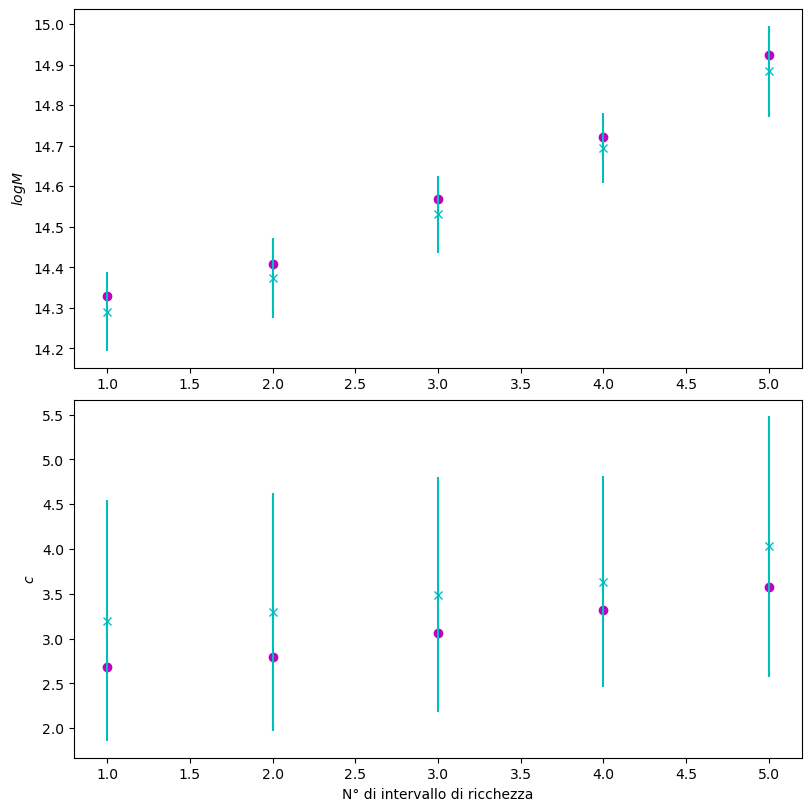

In [9]:
#Ora facciamo un plot per rendere più evidenti i risultati
fig,ax = plt.subplots(2, figsize=(8,8), layout='constrained')
for i in range(5):
    ax[0].plot(i+1, bfit[i,0], 'o', color='m')
    ax[0].errorbar(i+1, logM_mid_chain[i], logM_stdev_chain[i], xerr=None, color='c', fmt='x')
    ax[1].plot(i+1, bfit[i,1], 'o', color='m')
    ax[1].errorbar(i+1, c_mid_chain[i], c_stdev_chain[i], xerr=None, color='c', fmt='x')

ax[0].set_ylabel("$logM$")
ax[1].set_ylabel("$c$")
ax[-1].set_xlabel("N° di intervallo di ricchezza")
plt.show()

Osservando i grafici ci si rende subito conto di quanto detto prima: tutti i punti di best fit rientrano entro meno di una deviazione standard dai punti calcolati dalle chain. Guardando invece i grafici triangolari si nota che le ditribuzioni assomigliano a delle Gaussiane ma legegrmente asimmetriche.
Va notato inoltre che tutti i punti di best fit di $logM$ sono sopra i punti medi calcolati mentre i best fit di $c$ sono sempre sotto. Questo è dato dal fatto che le distribuzioni sono asimmetriche. 

Calcoliamo ora il $\chi^2$ per ogni intervallo di ricchezza e confrontare la NFW calcolata con i best fit con i dati estratti a caso dalla chain.

Valori dei Chi quadri: [0.46890869 0.37731815 0.21717307 0.13750378 0.05396714]


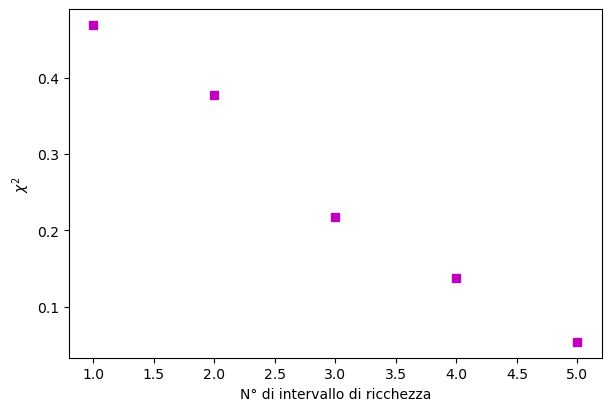

In [11]:
X2 = np.zeros(5)
#implemento il calcolo di X2 per ogni intervallo di ricchezza
for i in range(5):
    chi = (NFW(Rdati, 10**bfit[i,0], bfit[i,1], redsh_mid[i]) - prof_dens_mid[i])**2/((prof_dens_stdev[i])**2)
    X2[i] = sum(chi) #serve per sommare su tutti i raggi

print("Valori dei Chi quadri:", X2)

# Anche se non serve, vediamo gli andamenti del chi quadro al veriare della ricchezza
fig, ax = plt.subplots(1, 1, figsize=(6,4), layout='constrained')
for i in range(5):
    ax.plot(i+1, X2[i], 's', color='m', lw=2)

ax.set_xlabel("N° di intervallo di ricchezza")
ax.set_ylabel("$\chi^2$")
plt.show()

Avendo stimato due parametri ed essendo otto i raggi per ogni bin di ricchezza, il $\chi^2$ è a sei gradi di libertà. Fissata una soglia del 5% di rigettare l'ipotesi, il valore limite assumibile dal $\chi^2$ è 0,6757. Nel nostro caso tutti e 5 i $\chi^2$ sono inferiori a quel valore, dunque tutti i test sono non significativi. Questa ultima osservazione è l'ennesima conferma della validità della formula per i profili di densità degli aloni di materia oscura. Si può anche osservare che i valori de $\chi^2$ decrescono all'aumentare della ricchezza dell'intervallo, sebbene ciò non abbia grandi conseguenze ai fini dell'analisi fatta.

Osserviamo ora i profili di best fit rispetto ai profili veri forniti dai dati.

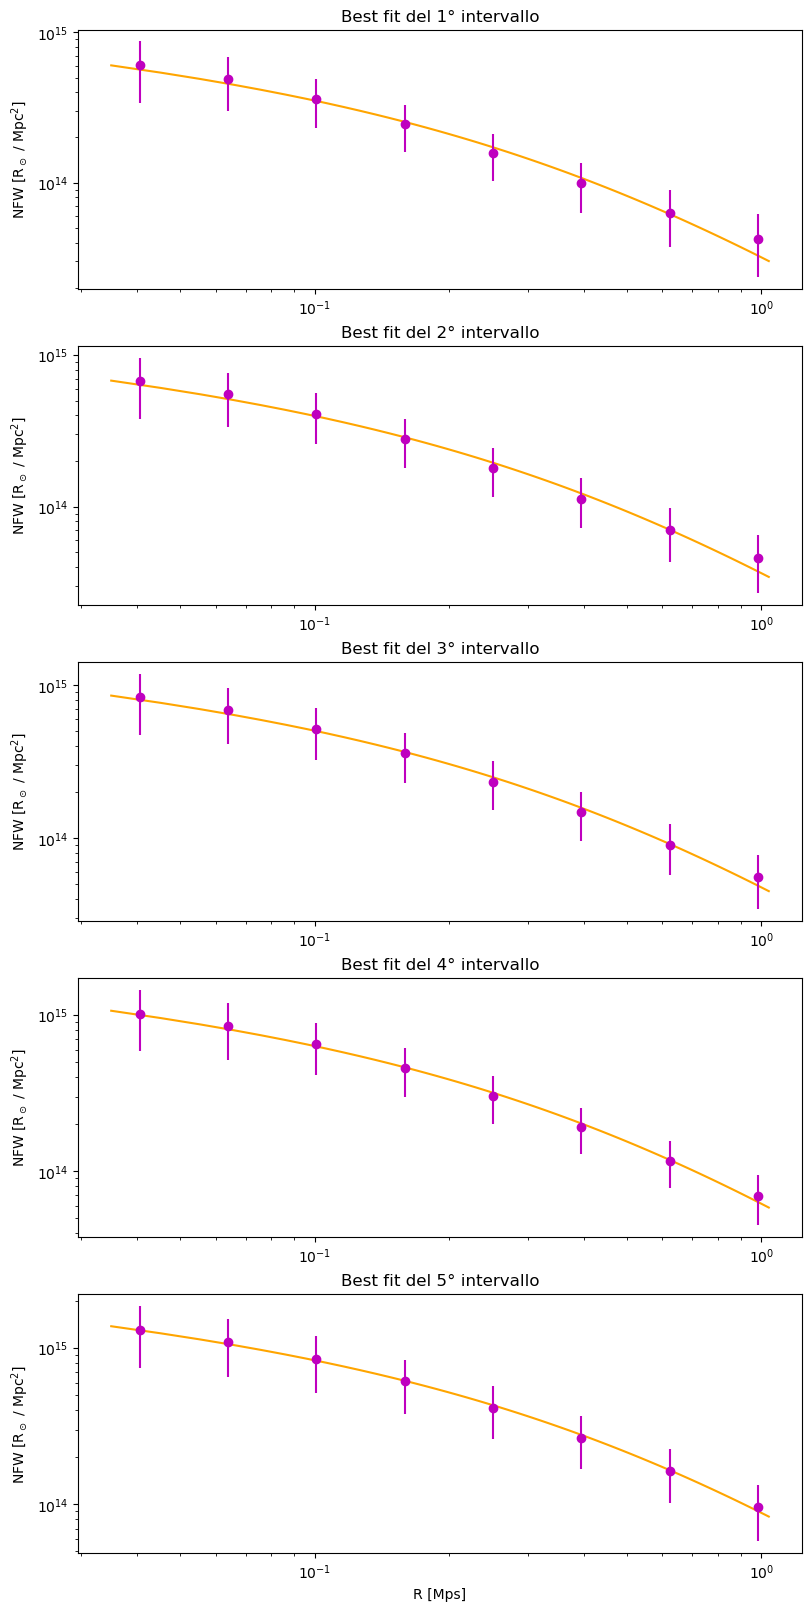

In [12]:
#xr = np.linspace(0.035, 1.04, 100)
fig, ax = plt.subplots(5, 1, figsize=(8,16), layout='constrained')
for i in range(5):
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].plot(xr, NFW(xr, 10**bfit[i,0], bfit[i,1], redsh_mid[i]), color='orange')
    ax[i].errorbar(Rdati, prof_dens_mid[i], prof_dens_stdev[i], fmt='o', color='m')
    ax[i].set_ylabel('NFW [R$_\odot$ / Mpc$^2$]')
    ax[i].set_title(f'Best fit del {i+1}° intervallo')
ax[-1].set_xlabel('R [Mps]')
plt.show()

Come ci si poteva aspettare dalle osservazioni fatte sul $\chi^2$, anche graficamente il risultato è molto soddisfacente. Ci permette, inoltre, di confermare che l'andamento è identico a quello ottenuto nel grafico a nove pannelli all'inizio.
Per ultimo, confrontiamo i profili per ogni intervallo di ricchezza con 100 parametri $M$ e $c$ dalle catene.

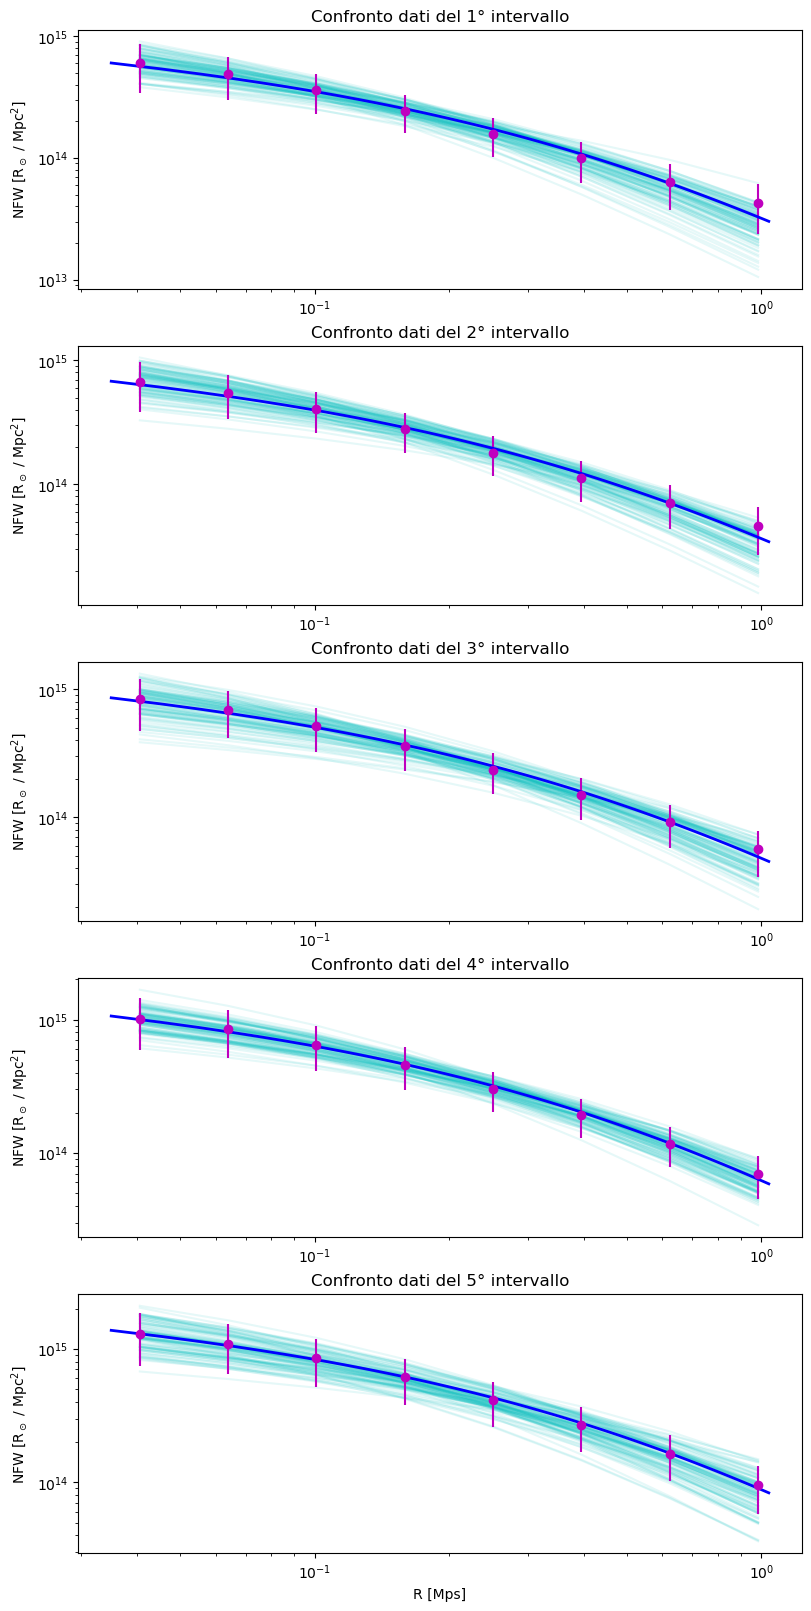

In [13]:
fig, ax = plt.subplots(5, 1, figsize=(8,16), layout='constrained')
indices = list(range(0,64000)) #elenca i numeri da 0 a 64000

for i in range(5):
    logM_rand = np.zeros(100)
    c_rand = np.zeros(100)
    prof_chain = np.zeros((8,100))
    for k in range(100):
        #random.shuffle(indices)
        k_indices = np.random.choice(indices, size=100, replace=False) #Prende cento numeri a caso dall'array indices senza ripetizioni
        t = k_indices[k] 
        logM_rand[k] = data_chain[i,t,0]
        c_rand[k] = data_chain[i,t,1]
        prof_chain[:,k] = NFW(Rdati, 10**(logM_rand[k]), c_rand[k], redsh_mid[i]) 
        #Ora grafichiamo tutti e 100 questi profili
    ax[i].set_xscale("log")
    ax[i].set_yscale("log") #Come sempre, scala loglog per visualizzare meglio i risultati
    ax[i].plot(Rdati, prof_chain, color='c', alpha=0.10)
    ax[i].errorbar(Rdati, prof_dens_mid[i], prof_dens_stdev[i], fmt='o', color='m')
    ax[i].plot(xr, NFW(xr, 10**bfit[i,0], bfit[i,1], redsh_mid[i]), color='blue', lw=2)
    ax[i].set_ylabel('NFW [R$_\odot$ / Mpc$^2$]')
    ax[i].set_title(f'Confronto dati del {i+1}° intervallo')
ax[-1].set_xlabel('R [Mps]')
plt.show()

Tracciando per ogni intervallo di ricchezza 100 curve si vede che tutte passano nelle vicinanze dei punti medi dei profili per ognuno degli 8 raggi entro al massimo 2 deviazioni standard. Questo ci dice che anche con altri valori di $logM$ e $c$ i profili seguono abbastanza bene l'andamento dei dati.

## Conclusioni:

In conclusione, i risultati analizzati dall'algoritmo emcee mostrano la validità della teoria dei profili d'onda delgi aloni di materia oscura secondo la NFW. Per tutti e 5 gli intervalli di ricchezza i risultati mostrano una chiara corrispondenza con i dati reali, sia graficamente che statisticamente come evidenziato dal test di $\chi^2$. 
